# Time series forecasting with Prophet

## Motivation

Prophet is a Python library for time series forecasting. It is a predictive model that can be used to predict future values of time series data. It is a general purpose forecasting library that can be used for many different types of time series data. It can be used to predict the future values of time series data, such as stock prices, sales, or any other time series data.

Not all for

## Basics

In prophet, there are three main components:
$$y_t = g(t) + s(t) + h(t) + \epsilon _t$$

where: 
1. $g(t)$ is the trend component, which is a linear function of the past $t$ time points.
2. $s(t)$ is the seasonal component, which is a sinusoidal function of the past $t$ time points.
3. $h(t)$ is the holiday component, which is a linear function of the past $t$ time points.

$\epsilon _t$ is the noise component, which is a random variable with a normal distribution.

### Trend $g(t)$

Two types of trend components are available in prophet: 
1. Linear trend, which is a linear function of the past $t$ time points.
2. A simpler version of the linear trend, which is a linear function of the past $t$ time points, with a constant offset.

### Seasonal $s(t)$

The seasonal component is modeled using a Fourier series. The Fourier series is a polynomial function of the past $t$ time points.

$$s(t) = \sum_{n=1}^N \left(a_n cos \frac{(2 \pi n t)}{P} + b_n sin \frac{(2 \pi n t)}{P} \right)$$

where, 
1. $N$ is the number of terms in the Fourier series. (N can be thought of as a way of increasing the sensitivity of our seasonality model. As we increase N, we allow for the model to capture more seasonal changes)
2. $P$ is the period of the seasonal component. (for yearly P = 365)
3. $a_n$ and $b_n$ are the coefficients of the Fourier series.

### Holiday $h(t)$

The last component is the holiday component. If we pass a list of holidays to the model, for each holiday i we let Di be the set of past and future dates for those holidays. Those holidays are incorporated as vectors of indicator functions (ie. for each time t in our data set, it has a 1 for each holiday occurring on that day, and a bunch of zeroes). These vectors should be very sparse.

$$h(t) = [1(t \in D_1), \dots , 1 (t \in D_L)$$



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg
import datetime
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import time
from sklearn.metrics import mean_squared_error
from matplotlib import dates as mdates
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use("ggplot")

import utils.settings_utils as settings
import utils.DatasetAccess as db_access
import utils.preprocess as preprocess
import utils.prophet_experiment as exp

Importing plotly failed. Interactive plots will not work.


In [2]:
conn = pg.connect(database=settings.get_database(), user=settings.get_user(), password=settings.get_pasword())

In [3]:
def get_preprocessed_dataset(company, interval, time_limit='0001-01-01 00:00:00'):
    df_d = db_access.get_data_for_datasetid(company, conn, interval, time=time_limit)
    df_d = preprocess.rename_dataset_columns(df_d)
    return df_d

In [4]:
def get_ds_end_start_date(df, time_col='ds'):
    return df.iloc[-1][time_col], df.iloc[0][time_col]

In [5]:
def fit_model_with_dataset(df):
    model = Prophet(
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=False,
        interval_width=0.95
    )
    model.fit(df)
    return model

In [6]:
def perform_cross_validation_on_horizon(model, horizon, period=None, initial=None):
    if period == None or initial == None:
        return cross_validation(model, horizon=horizon)
    else:
        return cross_validation(model, horizon=horizon, period=period, initial=initial)


In [7]:
def get_peformance_metrics(df):
    return performance_metrics(df)

In [8]:
def populate_df(metric_name, df, metrics, df_columns, name, run_time, avg_time):
    std = preprocess.std_on_column(metrics, metric_name)
    avg = preprocess.avg_on_column(metrics, metric_name)
    min = preprocess.min_on_column(metrics, metric_name)
    max = preprocess.max_on_column(metrics, metric_name)
    
    new_row = [[name, run_time, avg_time, avg, std, min, max]]
    
    new_df = pd.DataFrame(new_row, columns=df_columns)
    df = pd.concat([df, new_df], axis=0)
    
    return df

In [9]:
e = exp.Experiment('D', 2)


In [10]:
ds = get_preprocessed_dataset(15611, e.get_time_unit(), time_limit='2000-01-01 00:00:00') # 15521
ds =ds.rename(columns={"close":"y"})
ds.head()

c:\Users\Stonker69\Documents\GitHub\BiksStonks\Forcasting_Models\stonkenv\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,ds,open,high,low,y,volume
0,2020-03-04,139.44,141.08,138.88,140.44,1.874645e+06
1,2020-03-05,141.92,142.08,139.16,140.16,2.502585e+06
2,2020-03-06,136.76,137.88,134.12,135.20,3.487180e+06
3,2020-03-09,126.00,130.60,124.00,127.48,5.626570e+06
4,2020-03-10,127.48,131.00,124.92,125.92,5.573260e+06


In [11]:
m = Prophet(mcmc_samples=300, seasonality_mode='multiplicative')
m.add_regressor('open', prior_scale=0.5, mode='multiplicative')
m.add_regressor('high', prior_scale=0.5, mode='multiplicative')
m.add_regressor('low', prior_scale=0.5, mode='multiplicative')
m.add_regressor('volume', prior_scale=0.5, mode='multiplicative')

In [12]:
m.fit(ds)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


50
ds
2020-03-04    0.977275
2020-03-05    0.991452
2020-03-06    1.005581
2020-03-09    1.020103
2020-03-10    1.016731
                ...   
2022-02-28    0.964564
2022-03-01    0.962862
2022-03-02    0.964643
2022-03-03    0.977275
2022-03-04    0.991452
Name: seasonal, Length: 502, dtype: float64


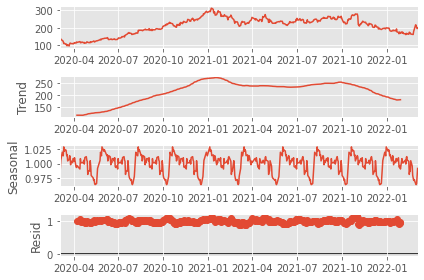

In [13]:

df = ds[['ds','y']]
df.index = df['ds']
df = df.drop('ds',1)


period = int(0.1* len(df))
print(period)

res = seasonal_decompose(df,model='multiplicative', period=period)

observed = res.observed
trend = res.trend
seasonal = res.seasonal
resid = res.resid

df_decomb = pd.DataFrame({"observed":observed, "seasonal":seasonal, "trend":trend, "resid":resid})
res.plot()
print(res.seasonal)


In [76]:
# years = mdates.
# months = mdates.MonthLocater()
# years_format = mdates.DateFormatter('%Y-%b')
# fmt = mdates.DateFormatter('%b')

AttributeError: module 'matplotlib.dates' has no attribute 'YearLocater'

In [14]:
end_date, start_date = get_ds_end_start_date(ds)

end_date, start_date

(Timestamp('2022-03-04 00:00:00'), Timestamp('2020-03-04 00:00:00'))

<AxesSubplot:xlabel='ds'>

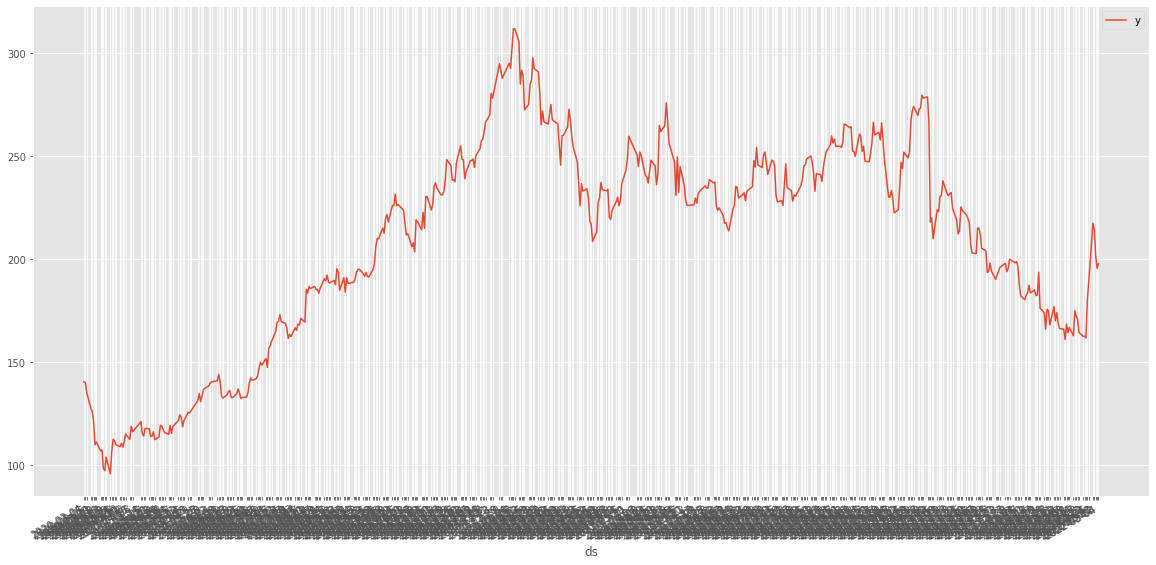

In [15]:
intervals_week = []

for i in range(0, len(ds["ds"]), 1):
    intervals_week.append(ds["ds"][i])

intervals_month = [intervals_week[i] for i in range(0, len(intervals_week), 1)]

ds.plot(x='ds', y=['y'], figsize=(20,10), xticks=intervals_month)

In [16]:
e.get_horizon(), e.get_time_unit(), e.get_initial(end_date, start_date), e.get_str_initial(end_date, start_date)

('2 days', 'D', 666.0, '666 days')

In [17]:
df_columns = ['name', 'runtime', 'avg_time', 'mse_avg', 'mse_std', 'mse_min', 'mse_max']
results = pd.DataFrame(columns=df_columns)#, 'mae_avg', 'mae_std', 'mae_min', 'mae_max'])


forecast_count = 32
start_time = time.time()

# model = fit_model_with_dataset(ds)

model = Prophet(mcmc_samples=300, seasonality_mode='multiplicative')
model.add_regressor('open', prior_scale=0.5, mode='multiplicative')
model.add_regressor('high', prior_scale=0.5, mode='multiplicative')
model.add_regressor('low', prior_scale=0.5, mode='multiplicative')
model.add_regressor('volume', prior_scale=0.5, mode='multiplicative')

model.fit(ds)

cross_val = perform_cross_validation_on_horizon(model, e.get_horizon(), e.get_horizon(), e.get_str_initial(end_date, start_date, forecast_count=forecast_count))
metrics = get_peformance_metrics(cross_val)
end_time = time.time()
run_time = end_time - start_time

results = populate_df('mse', results, metrics, df_columns, e.get_horizon(), run_time, run_time/forecast_count)

results

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 27 forecasts with cutoffs between 2022-01-01 00:00:00 and 2022-03-02 00:00:00


,name,runtime,avg_time,mse_avg,mse_std,mse_min,mse_max
0,2 days,3749.637934,117.176185,24.745958,4.352711,21.668126,27.823789


In [18]:
cross_val.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-01-03,199.523934,192.358606,199.087707,198.30,2022-01-01
1,2022-01-04,205.596926,198.951873,205.851840,198.85,2022-01-03
2,2022-01-05,197.761121,191.416034,198.178053,196.85,2022-01-03
3,2022-01-06,191.194571,184.404122,190.868222,187.70,2022-01-05
4,2022-01-07,187.686465,180.886815,187.640592,182.25,2022-01-05


<AxesSubplot:xlabel='ds'>

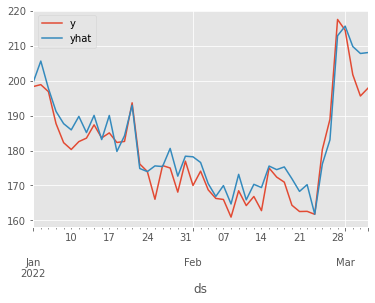

In [19]:
cross_val.plot(x='ds', y=['y', 'yhat'])

In [165]:
def cycle_analysis(data, split_date, cycle, fourier_order=8, mode='additive', forecast_plot=False, print_ind=False):
    """_summary_

    Args:
        data (_type_): Pandas dataframe with time index
        split_date (_type_): The date to split training and testing data 
        cycle (_type_): Periods (days) per cycle
        mode (str, optional): Additive or multiplicative for seasonality. Defaults to 'additive'.
        forecast_plot (bool, optional): Whether to print the forecast plot or not. Defaults to False.
        print_ind (bool, optional): WHether to print the projected return per cycle and out-sample mean squared error or not. Defaults to False.
    """


    training = data[data['ds'] <= split_date]# data[:split_date].iloc[:-1]
    testing = data[data['ds'] > split_date]
    predict_period = len(testing['ds'])
    df = training.reset_index()
    df.colums=['ds', 'y']
    df.plot(x='ds', y=['y'])
    model = Prophet(
        weekly_seasonality=False, yearly_seasonality=False, daily_seasonality=False
    ).add_seasonality(
        'self_defined_cycle', period=cycle, fourier_order=fourier_order, mode=mode
    )

    print(df.head())

    
    model.add_regressor('open', prior_scale=0.5, mode='multiplicative')
    model.add_regressor('high', prior_scale=0.5, mode='multiplicative')
    model.add_regressor('low', prior_scale=0.5, mode='multiplicative')
    model.add_regressor('volume', prior_scale=0.5, mode='multiplicative')

    model.fit(df)
    
    future = model.make_future_dataframe(periods=predict_period, freq='D', include_history=True)
    forecast=model.predict(future)
    if forecast_plot:
        model.plot(forecast)
        plt.plot(testing.ds, testing.y, '.', color='#ff3333', alpha=0.6)
        model.plot_components(forecast)
    
    # ret = max(forecast.self_defined_cycle)-min(forecast.self_defined_cycle)
    model_tb=forecast['yhat']
    model_tb.index = forecast['ds'].map(lambda x:x.strftime('%Y-%m-%d'))



    # out_tb = pd.concat([testing, model_tb], axis=1)
    # out_tb = out_tb[~out_tb.iloc[:,0].isnull()]
    # out_tb = out_tb[~out_tb.iloc[:,1].isnull()]
    # print(out_tb.iloc[:,0])
    # print(out_tb.iloc[:,1])
    # mse = mean_squared_error(out_tb.iloc[:,0], out_tb.iloc[:,1])
    # rep=[ret, mse]

    # if print_ind:
    #     print("Projected return per cycle: {}".format(round(rep[0], 2)))
    #     print("MSE: {}".format(round(rep[1], 4)))
    # return rep

C:\Users\Stonker69\AppData\Local\Temp\ipykernel_7180\1432064619.py:18: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.colums=['ds', 'y']


   index         ds       y
0      0 2020-03-04  140.44
1      1 2020-03-05  140.16
2      2 2020-03-06  135.20
3      3 2020-03-09  127.48
4      4 2020-03-10  125.92


c:\Users\Stonker69\Documents\GitHub\BiksStonks\Forcasting_Models\stonkenv\lib\site-packages\fbprophet\plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


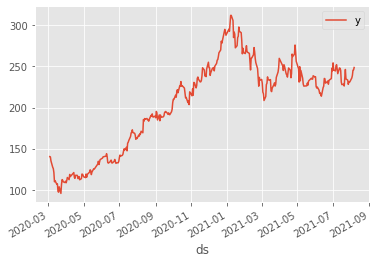

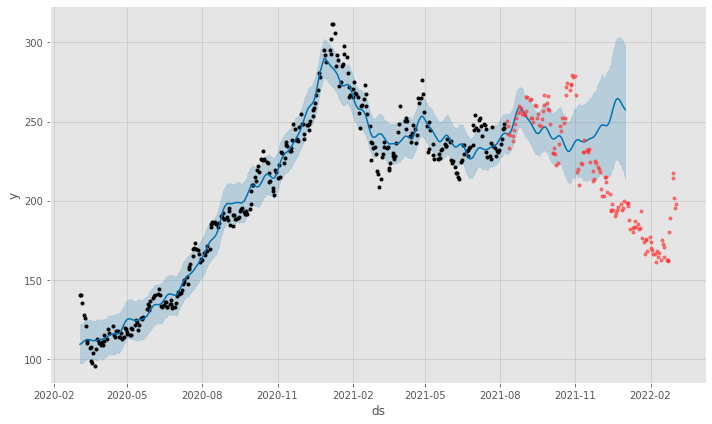

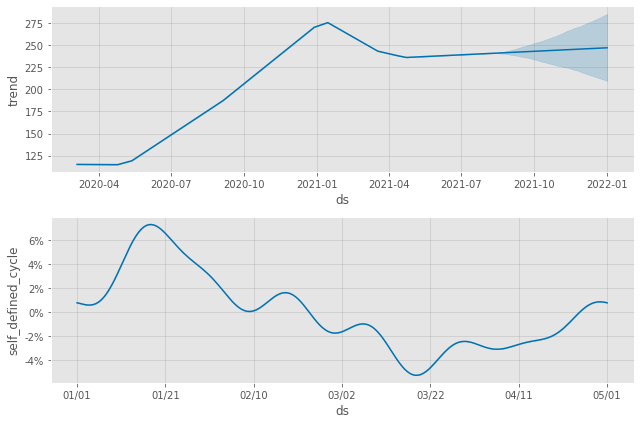

In [166]:


split_date = (end_date - ((end_date - start_date) * 0.3))
# cycle_analysis(ds, split_date, 120, fourier_order=8, mode='multiplicative', forecast_plot=True, print_ind=True)
cycle_analysis(ds[['ds', 'y']], split_date, 120, fourier_order=8, mode='multiplicative', forecast_plot=True, print_ind=True)

# training = new[:split_date].iloc[:-1]